In [1]:
using Pkg
Pkg.activate(".")

 Activating environment at `~/projects/practicas/carmen/Practicas_CloudScat/Project.toml`


In [2]:
# Estos comandos son para descargar los paquetes necesarios.  No es necesario que los ejecutes.
# using Pkg
# Pkg.add(PackageSpec(url="http://github.com/aluque/CloudScat.jl"))
# Pkg.add("StaticArrays")
# Pkg.add("GR")
# Pkg.add("Plots")
# Pkg.add("PlotThemes")
# Pkg.add("Revise")
# Pkg.add("Plotly")

In [3]:
# Inicializamos las librerías.  Esto puede tardar un poco pero hay que hacerlo sólo una vez en cada sesión.
using Revise
using StaticArrays
using CloudScat
using Plots
const co = CloudScat.constants

# Incialización del formato de figuras
gr(framestyle=:box)

Plots.GRBackend()

In [4]:
"""
    setup(m)

Ajusta los parámetros del modelo.
"""
function setup(m)
    params = Params(
        # NUmber of simulated photons
        N = 100000,

        # The wavelength of the scattered light
        λ = 337 * co.nano,

        # The source is defined as a straight line running from source_a
        # to source_b.  Within this line photons are distributed uniformly with
        # initially random, isotropic directions.  To use a point source set
        # source_b = source_a
        source_a = [0, 0, 8 * co.kilo],
        source_b = [0, 0, 13 * co.kilo])


    observers = [Observer(
        # Location of the observer,position can be evaulated from [x0,y0] in test_projection.m at altitude of source_a
        position = [0, 0, 400 * co.kilo],
        
        # Sampling interval
        tsample = 1e-5,
        
        # Collected samples
        nsamples = 10000,
        
        # fov of the camera (half of the diagonal fov).
        fov = 40,
        
        # camera pixels
        pixels = 1024)]
    
    # World geometry
    # Describe the cloud geometry here.  It may consist in combinations of
    # geometrical figures (cylinders, spheres, cones, semi-planes).
    # See cloud_gemoetry.jl for a more detailed description
    #
    # Now a cone on the axis
    cone = Cone(7 * co.kilo, 15 * co.kilo, 0, 0, 25 * co.kilo, m)

    # Finally we combine everything together
    cloud = cone
    
    # Geometry of the full domain.  Photons outside the domain are
    # immediately discarded.
    domain = Cylinder(7 * co.kilo, 60 * co.kilo, 0, 0, 200 * co.kilo)
    
    # Set a homogeneous cloud droplet density and radius.
    # See variable_droplet_radius.jl for how to deal with inhomogeneous clouds.
    # Radius of the scattering particles
    radius = 10e-6
    
    # Density of the scattering centers.
    nscat = 100 * co.centi^-3

    # The refindex keyword is used to specify a data file with the refraction
    # index table, specified as
    # wavelengh (micrometers)   n(real part)   n(imaginary part)
    # For ice use WarrenBrandt.dat
    composition = Homogeneous(params.λ, nscat, radius, refindex="Hale.dat",
                              verbose=false)
    
    # Define the full simulation world
    world = World(cloud, domain, composition)

    # Observers record a time curve and an image of received light.  You can
    # set up as many observers as you wish but they have a significant impact
    # on performance.

    return (params=params, world=world, observers=observers)
end


  #  print_mathematica(observer, cloud)

#Print the Mathematica code to render a 3d view of the `cloud` as seen from `observer`

#function print_mathematica(observer, cloud)
#    viewpoint = "{" * join(observer.r, ", ") * "}"
#    viewdir = "{" * join([observer.r[1], observer.r[2], 0.0],  ", ") * "}"
#    println("To visualize the cloud geometry with Mathematica use:")
#   println()
#    println("R = ", mathematica(cloud))
#   println("""RegionPlot3D[R, PlotTheme -> "Classic", Axes -> True,
#       PlotStyle -> Directive[Opacity[0.75], RGBColor[.6, .65, .85],
#           Specularity[0.2]],
#       Lighting -> "Neutral", PlotPoints -> 100,
#       ViewVector -> {$viewpoint, $viewdir}]
#   """)
#   println()
#end



setup

In [19]:
am = 0.75:0.75:3
for m in am
    global result_list
    inputs = setup(m);
    result = CloudScat.main(inputs...);
    # Miramos si ya hemos empezado a construir la lista de resultados
    if @isdefined result_list
        push!(result_list, result)
    else
        # Si todavía no tenemos una lista de resultados empezamos a construirla
        result_list = [result]
    end
end

[ 2020-07-27T14:41:38.09 : CloudScat (c) Alejandro Luque IAA-CSIC, 2020
[ 2020-07-27T14:41:38.09 : Mie solver by Olli Wilkman (https://github.com/dronir/MieScatter.jl)
┌ 2020-07-27T14:41:38.092: Input parameters:
│   params =
│    {
│        zmin        = 9000.0                  # Min z for observations 
│        source_a    = [0.0, 0.0, 8000.0]      # Location of point a of the source 
│        source_b    = [0.0, 0.0, 13000.0]     # Location of point b of the source 
│        N           = 100000                  # Initial number of photons 
│        λ           = 3.37e-7                 # Wavelength 
│        weight_min  = 0.01                    # Minimum weight: below, particles are subjected to Russian roulette 
│        σray        = 3.4371080894577986e-30  # Cross-section for Rayleigh scattering 
│        max_iter    = 1000000000              # Maximum number of collisions per photon 
│        nair        = 2.6867811e25            # Air density at ground level (z = 0) 
│       

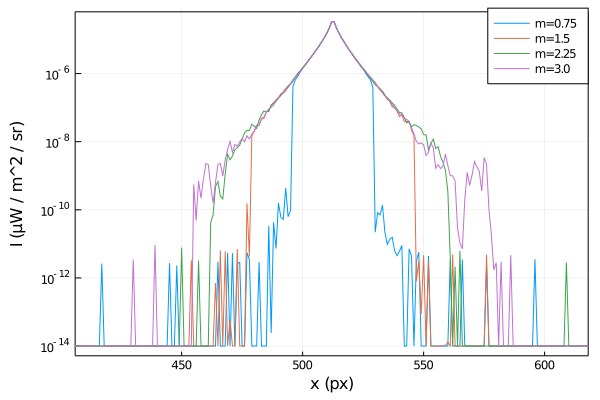

In [24]:
plot()
for (m, result) in zip(am, result_list)
    plot!(image(result[1])[512, :] .+ 1e-14, label="m=$m")
end
plot!(xlims=512 .+ [-100,+100], ylabel="I (μW / m^2 / sr)", yscale=:log10, xlabel="x (px)")